In [1]:
!nvidia-smi

Sat Oct 21 14:56:14 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8               2W / 136W |   3092MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
from torch import nn
from torch.nn import functional as F
import torch
from torch import optim
from torchvision import datasets,transforms
from torchinfo import summary

In [3]:
from transformations import train_transforms,test_transforms

In [4]:
from trainer import Trainer
from tester import Tester
from utlis import visualize_data,show_misclassified_images,device,is_cuda
from viz import plot_class_distribution, plot_confusion_matrix, plot_curves
from dataloader import CIFAR10Dataset,CIFAR10DataLoader
from models import ConvLayer,TransBlock,DepthwiseConvLayer

In [5]:
# ALbumentation
train_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=train_transforms,download=False)
test_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)

cifar = CIFAR10DataLoader()
train_loader,test_loader = cifar.get_loader(train_dataset,test_dataset)

In [6]:
# cifar = CIFAR10DataLoader()
# simple_train_loader , simple_test_loader = cifar.get_loader(
#     CIFAR10Dataset(root='../data/',train=True,Atransforms=test_transforms,download=False),
#     CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
# )

# Resnet like Architecture

In [7]:
# We used this Squeeze-Expand Network before
class Net1(nn.Module):
    def __init__(self):
        super(Net1,self).__init__()
        self.dp_rate = 0.2

        self.c1 = ConvLayer(inc=3,outc=16,s=1,k=3,p=1,d=1,dp_rate=self.dp_rate)
        self.c2 = ConvLayer(inc=16,outc=16,s=1,p=1,k=3,d=1,dp_rate=self.dp_rate)
        self.c3 = ConvLayer(inc=16,outc=32,s=2,p=1,d=1,k=3,dp_rate=self.dp_rate)
        
        self.c4 = ConvLayer(inc=32,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c5 = ConvLayer(inc=32,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c6 = ConvLayer(inc=32,outc=32,k=3,s=2,p=1,d=1,dp_rate=self.dp_rate)

        self.c7 = ConvLayer(inc=32,outc=60,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c8 = ConvLayer(inc=60,outc=60,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c9 = nn.Sequential(
            nn.Conv2d(in_channels=60,out_channels=60,kernel_size=3,stride=2,dilation=1,padding=1,bias=False)
        )

        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.c10 = nn.Conv2d(60,10,kernel_size=1,bias=False)
    def forward(self,x):
        x = self.c1(x)
        x = x + self.c2(x)
        x = self.c3(x)
        
        x = x+self.c4(x)
        x = x+self.c5(x)
        x = self.c6(x)

        x = self.c7(x)
        x = x + self.c8(x)
        x = self.c9(x)

        x = self.gap(x)
        x = self.c10(x)
        return F.log_softmax(x.view(-1,10), dim=1)

In [8]:
simple_model = Net1().to(device)
summary(simple_model,(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Net1                                     [1, 10]                   --
├─ConvLayer: 1-1                         [1, 16, 32, 32]           --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 32, 32]           432
│    │    └─BatchNorm2d: 3-2             [1, 16, 32, 32]           32
│    │    └─ReLU: 3-3                    [1, 16, 32, 32]           --
│    │    └─Dropout2d: 3-4               [1, 16, 32, 32]           --
├─ConvLayer: 1-2                         [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-6             [1, 16, 32, 32]           32
│    │    └─ReLU: 3-7                    [1, 16, 32, 32]           --
│    │    └─Dropout2d: 3-8               [1, 16, 32, 32]           --
├─ConvLayer

In [9]:
prev_test_loss = float('inf')
simple_model = Net1().to(device)
optimizer = optim.SGD(simple_model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(simple_model, train_loader, optimizer, criterion, device)
tester = Tester(simple_model, test_loader, criterion, device)

for epoch in range(1, 5):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(simple_model.state_dict(),'./bmodels/simple_model_with_mp_rf44.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.86 | Batch = 390 | Accuracy = 24.45: 100%|█| 391/391 [00:16<00:00, 24.00it/s


Test set: Average loss: 0.0134, Accuracy: 3612/10000 (36.12%)


EPOCH = 2 | LR = 0.1 | Loss = 1.86 | Batch = 390 | Accuracy = 32.66: 100%|█| 391/391 [00:17<00:00, 22.75it/s


Test set: Average loss: 0.0124, Accuracy: 4264/10000 (42.64%)


EPOCH = 3 | LR = 0.1 | Loss = 1.63 | Batch = 390 | Accuracy = 35.82: 100%|█| 391/391 [00:16<00:00, 23.34it/s


Test set: Average loss: 0.0119, Accuracy: 4355/10000 (43.55%)


EPOCH = 4 | LR = 0.1 | Loss = 1.66 | Batch = 390 | Accuracy = 37.89: 100%|█| 391/391 [00:16<00:00, 23.39it/s


Test set: Average loss: 0.0114, Accuracy: 4604/10000 (46.04%)


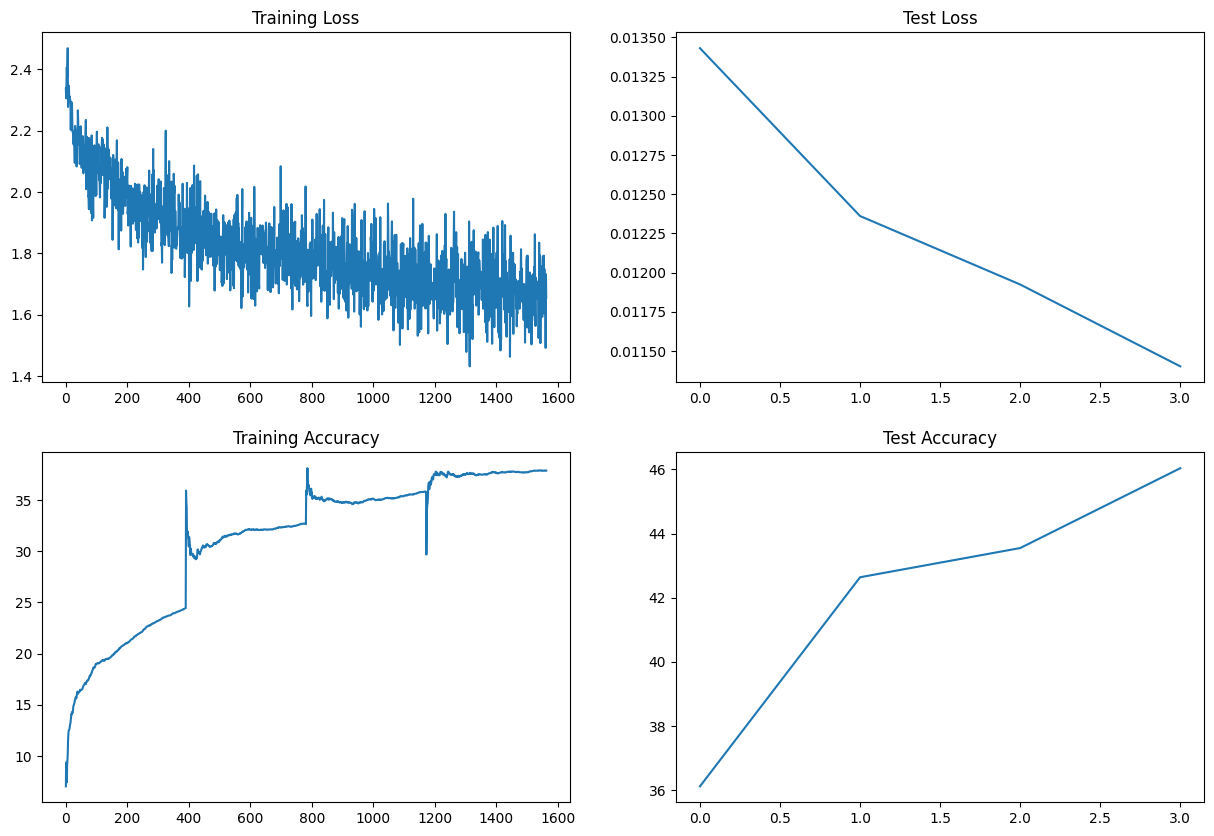

In [10]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

In [11]:
# We used this Squeeze-Expand Network before
class Net2(nn.Module):
    def __init__(self):
        super(Net2,self).__init__()
        self.dp_rate = 0.1

        self.c1 = ConvLayer(inc=3,outc=16,s=1,k=3,p=1,d=1,dp_rate=self.dp_rate)
        self.c2 = ConvLayer(inc=16,outc=16,s=1,p=1,k=3,d=1,dp_rate=self.dp_rate)
        self.c3 = ConvLayer(inc=16,outc=32,s=2,p=1,d=1,k=3,dp_rate=self.dp_rate)
        
        self.c4 = ConvLayer(inc=32,outc=40,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c5 = ConvLayer(inc=40,outc=40,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c6 = ConvLayer(inc=40,outc=40,k=3,s=2,p=1,d=1,dp_rate=self.dp_rate)

        self.c7 = ConvLayer(inc=40,outc=80,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c8 = ConvLayer(inc=80,outc=80,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c9 = nn.Sequential(
            nn.Conv2d(in_channels=80,out_channels=70,kernel_size=3,stride=2,dilation=1,padding=1,bias=False)
        )

        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.c10 = nn.Conv2d(70,10,kernel_size=1,bias=False)
    def forward(self,x):
        x = self.c1(x)
        x = x + self.c2(x)
        x = self.c3(x)
        
        x = self.c4(x)
        x = x+self.c5(x)
        x = self.c6(x)

        x = self.c7(x)
        x = x + self.c8(x)
        x = self.c9(x)

        x = self.gap(x)
        x = self.c10(x)
        return F.log_softmax(x.view(-1,10), dim=1)

In [12]:
model2 = Net2().to(device)
summary(model2,(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Net2                                     [1, 10]                   --
├─ConvLayer: 1-1                         [1, 16, 32, 32]           --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 32, 32]           432
│    │    └─BatchNorm2d: 3-2             [1, 16, 32, 32]           32
│    │    └─ReLU: 3-3                    [1, 16, 32, 32]           --
│    │    └─Dropout2d: 3-4               [1, 16, 32, 32]           --
├─ConvLayer: 1-2                         [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-6             [1, 16, 32, 32]           32
│    │    └─ReLU: 3-7                    [1, 16, 32, 32]           --
│    │    └─Dropout2d: 3-8               [1, 16, 32, 32]           --
├─ConvLayer

In [13]:
prev_test_loss = float('inf')
model2 = Net2().to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(model2, train_loader, optimizer, criterion, device)
tester = Tester(model2, test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(model2.state_dict(),'./bmodels/simple_model_with_mp_rf44_resnet.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.83 | Batch = 390 | Accuracy = 25.89: 100%|█| 391/391 [00:18<00:00, 20.62it/s


Test set: Average loss: 0.0131, Accuracy: 3695/10000 (36.95%)


EPOCH = 2 | LR = 0.1 | Loss = 1.76 | Batch = 390 | Accuracy = 35.15: 100%|█| 391/391 [00:18<00:00, 21.00it/s


Test set: Average loss: 0.0118, Accuracy: 4456/10000 (44.56%)


EPOCH = 3 | LR = 0.1 | Loss = 1.56 | Batch = 390 | Accuracy = 39.09: 100%|█| 391/391 [00:16<00:00, 23.15it/s


Test set: Average loss: 0.0107, Accuracy: 5082/10000 (50.82%)


EPOCH = 4 | LR = 0.1 | Loss = 1.51 | Batch = 390 | Accuracy = 42.73: 100%|█| 391/391 [00:17<00:00, 22.93it/s


Test set: Average loss: 0.0100, Accuracy: 5456/10000 (54.56%)


EPOCH = 5 | LR = 0.1 | Loss = 1.41 | Batch = 390 | Accuracy = 45.67: 100%|█| 391/391 [00:19<00:00, 20.41it/s


Test set: Average loss: 0.0093, Accuracy: 5743/10000 (57.43%)


EPOCH = 6 | LR = 0.1 | Loss = 1.53 | Batch = 390 | Accuracy = 47.93: 100%|█| 391/391 [00:17<00:00, 22.85it/s


Test set: Average loss: 0.0093, Accuracy: 5670/10000 (56.70%)


EPOCH = 7 | LR = 0.1 | Loss = 1.67 | Batch = 390 | Accuracy = 49.66: 100%|█| 391/391 [00:17<00:00, 22.44it/s


Test set: Average loss: 0.0083, Accuracy: 6205/10000 (62.05%)


EPOCH = 8 | LR = 0.1 | Loss = 1.61 | Batch = 390 | Accuracy = 50.97: 100%|█| 391/391 [00:18<00:00, 21.26it/s


Test set: Average loss: 0.0084, Accuracy: 6105/10000 (61.05%)


EPOCH = 9 | LR = 0.1 | Loss = 1.29 | Batch = 390 | Accuracy = 52.36: 100%|█| 391/391 [00:16<00:00, 24.08it/s


Test set: Average loss: 0.0092, Accuracy: 5861/10000 (58.61%)


EPOCH = 10 | LR = 0.1 | Loss = 1.04 | Batch = 390 | Accuracy = 53.57: 100%|█| 391/391 [00:18<00:00, 21.62it/


Test set: Average loss: 0.0078, Accuracy: 6501/10000 (65.01%)


EPOCH = 11 | LR = 0.1 | Loss = 1.14 | Batch = 390 | Accuracy = 54.73: 100%|█| 391/391 [00:19<00:00, 20.52it/


Test set: Average loss: 0.0078, Accuracy: 6558/10000 (65.58%)


EPOCH = 12 | LR = 0.1 | Loss = 1.37 | Batch = 390 | Accuracy = 55.98: 100%|█| 391/391 [00:19<00:00, 20.44it/


Test set: Average loss: 0.0070, Accuracy: 6847/10000 (68.47%)


EPOCH = 13 | LR = 0.1 | Loss = 1.08 | Batch = 390 | Accuracy = 56.46: 100%|█| 391/391 [00:17<00:00, 22.78it/


Test set: Average loss: 0.0071, Accuracy: 6821/10000 (68.21%)


EPOCH = 14 | LR = 0.1 | Loss = 1.21 | Batch = 390 | Accuracy = 57.05: 100%|█| 391/391 [00:19<00:00, 20.29it/


Test set: Average loss: 0.0068, Accuracy: 6958/10000 (69.58%)


EPOCH = 15 | LR = 0.1 | Loss = 1.53 | Batch = 390 | Accuracy = 57.41: 100%|█| 391/391 [00:18<00:00, 20.78it/


Test set: Average loss: 0.0067, Accuracy: 7025/10000 (70.25%)


EPOCH = 16 | LR = 0.1 | Loss = 0.94 | Batch = 390 | Accuracy = 58.71: 100%|█| 391/391 [00:17<00:00, 22.97it/


Test set: Average loss: 0.0068, Accuracy: 6957/10000 (69.57%)


EPOCH = 17 | LR = 0.1 | Loss = 1.08 | Batch = 390 | Accuracy = 58.77: 100%|█| 391/391 [00:17<00:00, 22.63it/


Test set: Average loss: 0.0066, Accuracy: 7063/10000 (70.63%)


EPOCH = 18 | LR = 0.1 | Loss = 0.96 | Batch = 390 | Accuracy = 59.92: 100%|█| 391/391 [00:17<00:00, 22.20it/


Test set: Average loss: 0.0061, Accuracy: 7347/10000 (73.47%)


EPOCH = 19 | LR = 0.1 | Loss = 1.64 | Batch = 390 | Accuracy = 60.28: 100%|█| 391/391 [00:16<00:00, 23.34it/


Test set: Average loss: 0.0062, Accuracy: 7269/10000 (72.69%)


EPOCH = 20 | LR = 0.1 | Loss = 1.23 | Batch = 390 | Accuracy = 60.83: 100%|█| 391/391 [00:17<00:00, 22.37it/


Test set: Average loss: 0.0060, Accuracy: 7408/10000 (74.08%)


EPOCH = 21 | LR = 0.1 | Loss = 1.35 | Batch = 390 | Accuracy = 61.28: 100%|█| 391/391 [00:18<00:00, 20.88it/


Test set: Average loss: 0.0060, Accuracy: 7386/10000 (73.86%)


EPOCH = 22 | LR = 0.1 | Loss = 1.03 | Batch = 390 | Accuracy = 61.41: 100%|█| 391/391 [00:17<00:00, 22.73it/


Test set: Average loss: 0.0057, Accuracy: 7553/10000 (75.53%)


EPOCH = 23 | LR = 0.1 | Loss = 1.30 | Batch = 390 | Accuracy = 61.72: 100%|█| 391/391 [00:17<00:00, 22.88it/


Test set: Average loss: 0.0059, Accuracy: 7401/10000 (74.01%)


EPOCH = 24 | LR = 0.1 | Loss = 1.32 | Batch = 390 | Accuracy = 61.97: 100%|█| 391/391 [00:19<00:00, 20.50it/


Test set: Average loss: 0.0060, Accuracy: 7391/10000 (73.91%)


EPOCH = 25 | LR = 0.1 | Loss = 1.08 | Batch = 390 | Accuracy = 62.09: 100%|█| 391/391 [00:16<00:00, 23.47it/


Test set: Average loss: 0.0056, Accuracy: 7539/10000 (75.39%)


EPOCH = 26 | LR = 0.1 | Loss = 1.06 | Batch = 390 | Accuracy = 62.49: 100%|█| 391/391 [00:16<00:00, 23.62it/


Test set: Average loss: 0.0058, Accuracy: 7521/10000 (75.21%)


EPOCH = 27 | LR = 0.1 | Loss = 1.01 | Batch = 390 | Accuracy = 62.74: 100%|█| 391/391 [00:18<00:00, 21.04it/


Test set: Average loss: 0.0054, Accuracy: 7599/10000 (75.99%)


EPOCH = 28 | LR = 0.1 | Loss = 1.13 | Batch = 390 | Accuracy = 63.01: 100%|█| 391/391 [00:16<00:00, 24.07it/


Test set: Average loss: 0.0059, Accuracy: 7424/10000 (74.24%)


EPOCH = 29 | LR = 0.1 | Loss = 1.38 | Batch = 390 | Accuracy = 63.70: 100%|█| 391/391 [00:16<00:00, 23.79it/


Test set: Average loss: 0.0055, Accuracy: 7642/10000 (76.42%)


EPOCH = 30 | LR = 0.1 | Loss = 0.98 | Batch = 390 | Accuracy = 63.67: 100%|█| 391/391 [00:18<00:00, 21.62it/


Test set: Average loss: 0.0057, Accuracy: 7520/10000 (75.20%)


EPOCH = 31 | LR = 0.1 | Loss = 0.99 | Batch = 390 | Accuracy = 63.26: 100%|█| 391/391 [00:16<00:00, 23.21it/


Test set: Average loss: 0.0055, Accuracy: 7657/10000 (76.57%)


EPOCH = 32 | LR = 0.1 | Loss = 1.00 | Batch = 390 | Accuracy = 64.13: 100%|█| 391/391 [00:16<00:00, 23.61it/


Test set: Average loss: 0.0051, Accuracy: 7794/10000 (77.94%)


EPOCH = 33 | LR = 0.1 | Loss = 0.98 | Batch = 390 | Accuracy = 63.92: 100%|█| 391/391 [00:17<00:00, 21.74it/


Test set: Average loss: 0.0054, Accuracy: 7638/10000 (76.38%)


EPOCH = 34 | LR = 0.1 | Loss = 0.92 | Batch = 390 | Accuracy = 64.04: 100%|█| 391/391 [00:17<00:00, 22.53it/


Test set: Average loss: 0.0053, Accuracy: 7664/10000 (76.64%)


EPOCH = 35 | LR = 0.1 | Loss = 1.23 | Batch = 390 | Accuracy = 64.32: 100%|█| 391/391 [00:16<00:00, 23.53it/


Test set: Average loss: 0.0052, Accuracy: 7718/10000 (77.18%)


EPOCH = 36 | LR = 0.1 | Loss = 0.96 | Batch = 390 | Accuracy = 64.80: 100%|█| 391/391 [00:16<00:00, 23.07it/


Test set: Average loss: 0.0054, Accuracy: 7655/10000 (76.55%)


EPOCH = 37 | LR = 0.1 | Loss = 1.14 | Batch = 390 | Accuracy = 64.89: 100%|█| 391/391 [00:17<00:00, 21.82it/


Test set: Average loss: 0.0053, Accuracy: 7649/10000 (76.49%)


EPOCH = 38 | LR = 0.1 | Loss = 0.90 | Batch = 390 | Accuracy = 64.90: 100%|█| 391/391 [00:16<00:00, 23.65it/


Test set: Average loss: 0.0051, Accuracy: 7802/10000 (78.02%)


EPOCH = 39 | LR = 0.1 | Loss = 1.19 | Batch = 390 | Accuracy = 65.17: 100%|█| 391/391 [00:16<00:00, 23.14it/


Test set: Average loss: 0.0053, Accuracy: 7699/10000 (76.99%)


EPOCH = 40 | LR = 0.1 | Loss = 0.89 | Batch = 390 | Accuracy = 65.03: 100%|█| 391/391 [00:18<00:00, 20.71it/


Test set: Average loss: 0.0050, Accuracy: 7802/10000 (78.02%)


EPOCH = 41 | LR = 0.1 | Loss = 0.92 | Batch = 390 | Accuracy = 65.41: 100%|█| 391/391 [00:16<00:00, 23.25it/


Test set: Average loss: 0.0051, Accuracy: 7828/10000 (78.28%)


EPOCH = 42 | LR = 0.1 | Loss = 0.86 | Batch = 390 | Accuracy = 65.28: 100%|█| 391/391 [00:17<00:00, 22.94it/


Test set: Average loss: 0.0054, Accuracy: 7668/10000 (76.68%)


EPOCH = 43 | LR = 0.1 | Loss = 0.88 | Batch = 390 | Accuracy = 65.20: 100%|█| 391/391 [00:19<00:00, 20.50it/


Test set: Average loss: 0.0053, Accuracy: 7677/10000 (76.77%)


EPOCH = 44 | LR = 0.1 | Loss = 0.94 | Batch = 390 | Accuracy = 66.00: 100%|█| 391/391 [00:16<00:00, 23.81it/


Test set: Average loss: 0.0049, Accuracy: 7846/10000 (78.46%)


EPOCH = 45 | LR = 0.1 | Loss = 1.06 | Batch = 390 | Accuracy = 65.75: 100%|█| 391/391 [00:16<00:00, 23.84it/


Test set: Average loss: 0.0048, Accuracy: 7952/10000 (79.52%)


EPOCH = 46 | LR = 0.1 | Loss = 0.85 | Batch = 390 | Accuracy = 65.73: 100%|█| 391/391 [00:18<00:00, 20.97it/


Test set: Average loss: 0.0049, Accuracy: 7864/10000 (78.64%)


EPOCH = 47 | LR = 0.1 | Loss = 0.82 | Batch = 390 | Accuracy = 66.02: 100%|█| 391/391 [00:16<00:00, 24.30it/


Test set: Average loss: 0.0049, Accuracy: 7881/10000 (78.81%)


EPOCH = 48 | LR = 0.1 | Loss = 0.69 | Batch = 390 | Accuracy = 65.91: 100%|█| 391/391 [00:16<00:00, 23.74it/


Test set: Average loss: 0.0049, Accuracy: 7929/10000 (79.29%)


EPOCH = 49 | LR = 0.1 | Loss = 1.05 | Batch = 390 | Accuracy = 65.96: 100%|█| 391/391 [00:18<00:00, 21.61it/


Test set: Average loss: 0.0049, Accuracy: 7873/10000 (78.73%)


EPOCH = 50 | LR = 0.1 | Loss = 1.07 | Batch = 390 | Accuracy = 66.36: 100%|█| 391/391 [00:16<00:00, 23.08it/


Test set: Average loss: 0.0048, Accuracy: 7991/10000 (79.91%)


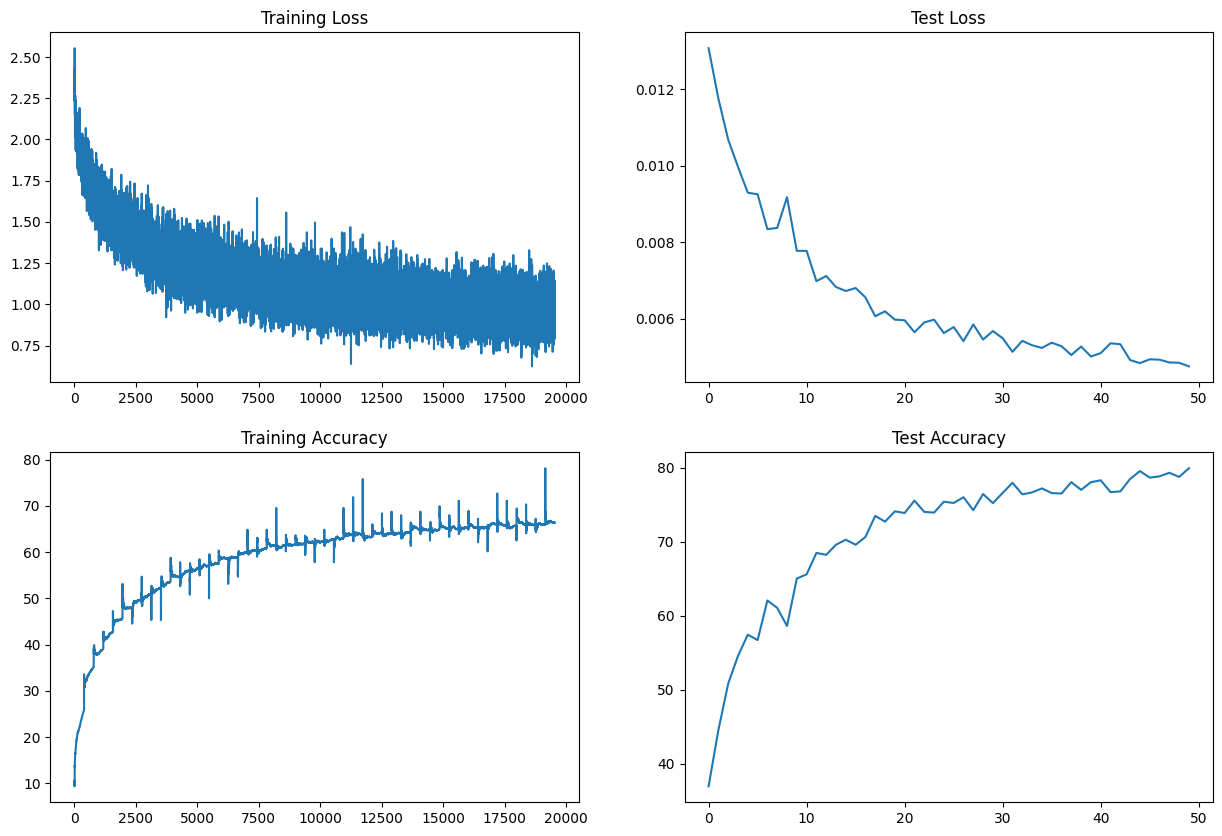

In [14]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)


In [15]:
# We used this Squeeze-Expand Network before
class Net2(nn.Module):
    def __init__(self):
        super(Net2,self).__init__()
        self.dp_rate = 0.1

        self.c1 = ConvLayer(inc=3,outc=16,s=1,k=3,p=1,d=1,dp_rate=self.dp_rate)
        self.c2 = ConvLayer(inc=16,outc=16,s=1,p=1,k=3,d=1,dp_rate=self.dp_rate)
        self.c3 = ConvLayer(inc=16,outc=32,s=1,p=1,d=2,k=3,dp_rate=self.dp_rate)

        self.t1 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=1,bias=False,padding=1)
        )

        
        self.c4 = DepthwiseConvLayer(inc=32,outc=40,k=1,s=1,p=1,dp_rate=self.dp_rate)
        self.c5 = ConvLayer(inc=40,outc=40,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c51 = ConvLayer(inc=40,outc=40,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c6 = ConvLayer(inc=40,outc=40,k=3,s=1,p=1,d=4,dp_rate=self.dp_rate)
        self.t2 = nn.Sequential(
            nn.Conv2d(in_channels=40,out_channels=40,kernel_size=1,bias=False,padding=1)
        )

        self.c7 = ConvLayer(inc=40,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c8 = ConvLayer(inc=64,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c81 = ConvLayer(inc=64,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c9 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,dilation=1,padding=1,bias=False),
            nn.Conv2d(in_channels=64,out_channels=32,kernel_size=1,stride=1,dilation=1,bias=False)
        )

        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.c10 = nn.Conv2d(32,10,kernel_size=1,bias=False)
    def forward(self,x):
        x = self.c1(x)
        x = x + self.c2(x)
        x = self.c3(x)
        x = self.t1(x)
        
        x = self.c4(x)
        x = x+self.c5(x)
        x = self.c51(x)
        x = self.c6(x)
        x = self.t2(x)
    
        x = self.c7(x) 
        x = self.c81(x)        
        x = x + self.c8(x)  
        x = self.c9(x)

        x = self.gap(x)
        x = self.c10(x)
        return F.log_softmax(x.view(-1,10), dim=1)

In [16]:
m = Net2().to(device)
summary(m,(1,3,32,32))

TypeError: DepthwiseConvLayer.__init__() got an unexpected keyword argument 'k'

In [ ]:
prev_test_loss = float('inf')
m = Net2().to(device)

optimizer = optim.SGD(m.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(m, train_loader, optimizer, criterion, device)
tester = Tester(m, test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(m.state_dict(),'./bmodels/my_model.pth')
    scheduler.step(test_loss)

In [ ]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# Dilated Kernels implementation

In [ ]:
class Net(nn.Module):
    def __init__(self,dp_rate):
        super(Net,self).__init__()
        self.dp_rate = dp_rate
    
        self.c1 = nn.Sequential(
            ConvLayer(inc=3,outc=8,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=8,outc=12,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=12,outc=16,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
        )

        self.c2 = nn.Sequential(
            ConvLayer(inc=16,outc=24,k=3,p=1,d=1,s=1,dp_rate=self.dp_rate),
            ConvLayer(inc=24,outc=24,k=3,p=0,s=1,d=1,dp_rate=self.dp_rate)
        )
        self.c3DiL = nn.Sequential(
            ConvLayer(inc=16,outc=24,s=1,p=1,d=2,k=3,dp_rate=self.dp_rate),
        )


        self.c4 = nn.Sequential(
            ConvLayer(inc=24,outc=30,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=30,outc=30,k=3,p=0,s=1,d=1,dp_rate=self.dp_rate),
        )


        self.c5DiL = nn.Sequential(
            ConvLayer(inc=24,outc=30,k=3,d=2,p=1,dp_rate=self.dp_rate,s=1)
        )

        self.c6 = nn.Sequential(
            ConvLayer(inc=30,outc=32,k=3,p=0,dp_rate=self.dp_rate,s=1,d=1),
            ConvLayer(inc=32,outc=36,k=3,p=0,dp_rate=self.dp_rate,s=1,d=1),
            ConvLayer(inc=36,outc=38,k=3,p=0,dp_rate=self.dp_rate,s=1,d=1),
            ConvLayer(inc=38,outc=40,k=3,p=0,dp_rate=self.dp_rate,s=1,d=1)
        )

        self.C7DiL = nn.Sequential(
            ConvLayer(inc=30,outc=36,k=3,p=0,dp_rate=self.dp_rate,s=1,d=2),
            ConvLayer(inc=36,outc=40,k=3,p=0,dp_rate=self.dp_rate,s=1,d=2)
        )

        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = nn.Conv2d(in_channels=40,out_channels=10,kernel_size=1,bias=False)
    
    def forward(self,x):

        # BLOCK ONE
        x = self.c1(x)
        path1 = self.c2(x)
        path2 = F.dropout2d(
                    F.relu_( 
                        F.batch_norm(
                            self.c3DiL(x),
                            torch.zeros(24,device=device), #mu=0
                            torch.ones(24,device=device),   # ones are fine for first training iter  
                            training=True,
                            momentum=0.9
                        )
                    ) # self.c3DiL(x)
                )
        x = path1 + path2

        # BLOCK TWO
        path1 = self.c4(x)
        path2 = F.dropout2d(
                    F.relu_( 
                        F.batch_norm(
                            self.c5DiL(x),
                            torch.zeros(30,device=device), #mu=0
                            torch.ones(30,device=device),   # ones are fine for first training iter  
                            training=True,
                            momentum=0.9
                        )
                    ) # self.c3DiL(x)
                )
        x = path1+path2 

        # BLOCK 4
        path1 = self.c6(x)
        path2  =F.dropout2d(
                    F.relu_( 
                        F.batch_norm(
                            self.C7DiL(x),
                            torch.zeros(40,device=device), #mu=0
                            torch.ones(40,device=device),   # ones are fine for first training iter  
                            training=True,
                            momentum=0.9
                        )
                    ) # self.c3DiL(x)
                )
        x = path1 + path2

        # GAP
        x = self.gap(x)

        # OUT BLOCK
        x = self.out(x)
        return F.log_softmax(x.view(-1,10), dim=1)

In [ ]:
model3 = Net(0.1).to(device)
summary(model3,(1,3,32,32),)

In [ ]:
prev_test_loss = float('inf')


optimizer = optim.SGD(model3.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(model3, simple_train_loader, optimizer, criterion, device)
tester = Tester(model3, simple_test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(model3.state_dict(),'./bmodels/simple_model_with_mp_rf44_resnet_with_dilation_kernel.pth')
    scheduler.step(test_loss)

In [ ]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

In [ ]:
model4 = Net(0.2).to(device)
summary(model4,(1,3,32,32),)


prev_test_loss = float('inf')


optimizer = optim.SGD(model4.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(model4, train_loader, optimizer, criterion, device)
tester = Tester(model4, test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(model3.state_dict(),'./bmodels/simple_model_with_mp_rf44_resnet_with_dilation_kernel_aug.pth')
    scheduler.step(test_loss)

In [ ]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)